# Import required modules

In [ ]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import backend as K
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from generator import Generator
from models import *
import h5py
import numpy as np
import sys
import os

# Set Tensorflow backend to avoid full GPU pre-loading

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config = config))

# Load data generator

This is required for loading some variables during testing.

In [2]:
print "Loading Generator"
gen = Generator(dataset_directory = '/scratch/jyotish/show_and_tell_coco/data', cnn_model = 'inception')

Loading Generator


# Testing

## Load models requred for training

In [ ]:
from IPython.display import Image
from process_images import *

%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

dataset_directory = '/scratch/jyotish/show_and_tell_coco/data/COCO/extracted'
img_list_file = 'val2014'
annFile = '{}/annotations/instances_{}.json'.format(dataset_directory, img_list_file)

coco=COCO(annFile)
imgIds = coco.getImgIds();

# img_filenames = ['2943023421_e297f05e11.jpg']
# img_directory = '/scratch/jyotish/show_and_tell_coco/data/COCO/extracted/test2014'

img_model, target_size, output_shape, preprocess_input = get_cnn_model('inception')

# Load previously saved model

In [ ]:
from keras.models import load_model

model = load_model('/scratch/jyotish/show_and_tell_coco/data/COCO/models/attention_3.h5')

# Model Visualization

## Model summary (text based)

In [ ]:
model.summary()

## Model summary (flow chart)

In [ ]:
# Someone fill this

## Testing images individually
The following code randomly selects an image from validation dataset which is not used for training and displays the caption for the image.

a pizza sitting on top of a wooden table next to a glass of beer.


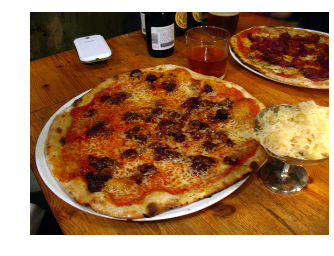

In [41]:
img_id = [imgIds[np.random.randint(0,len(imgIds))]]

preprocessed_images = build_image_features(img_id, coco, 
                         target_size, output_shape,
                         preprocess_input,
                         img_list_file, dataset_directory,
                         [])

preprocessed_images = np.asarray(preprocessed_images)
img_features = img_model.predict(preprocessed_images)
# img_features = np.asarray([img_features])
img = coco.loadImgs(img_id)[0]

text_in = np.zeros((1,gen.max_token_len))
text_in[0][:] = np.full((gen.max_token_len,), 0)
text_in[0][0] = gen.token_to_id['<start>']

predictions = []
for arg in range(gen.max_token_len-1):
    pred = model.predict([img_features, text_in])
    tok = np.argmax(pred[0][arg])
    word = gen.id_to_token[tok]
    text_in[0][arg+1] = tok
    if word == '<end>':
        break
    predictions.append(word)

print ' '.join(predictions) + '.'
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

## Visualize the attention map for the above test

Run this only after running the above block

a


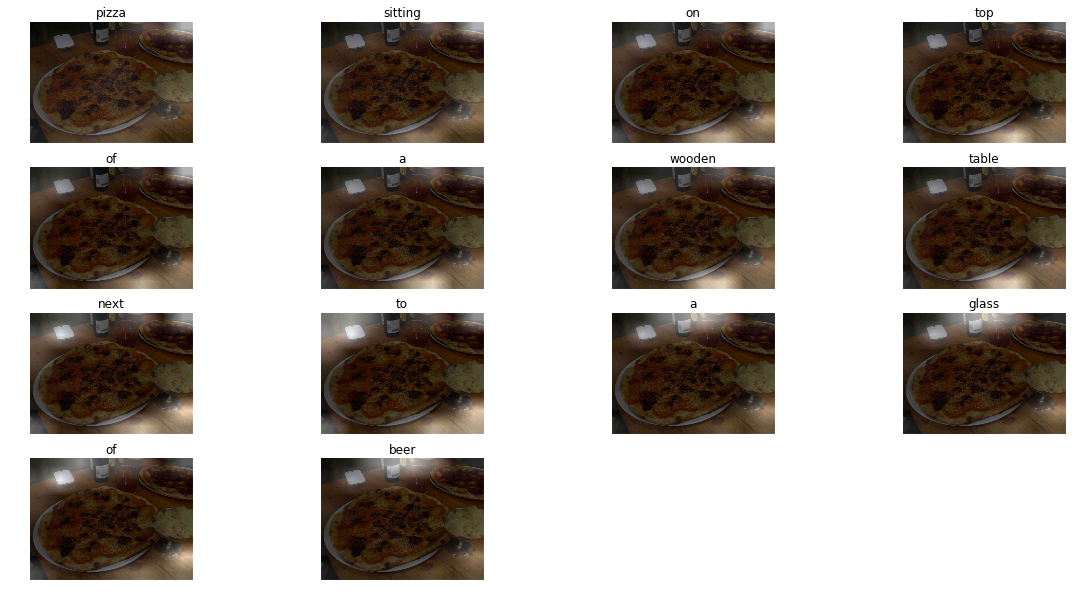

In [42]:
from matplotlib.pyplot import imshow
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

for i in range(1, len(predictions) - 1):
    text_in[0][i] = gen.token_to_id[predictions[i]]

layer_name = 'time_distributed_15'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

pred = intermediate_layer_model.predict([img_features, text_in])

plt.figure(figsize=(20,10))
columns = 4

print predictions[0]
for i in range(len(predictions) - 1):
    plt.subplot(len(predictions) / columns + 1, columns, i + 1)
    plt.imshow(I)
    att = pred[0,i,:].reshape((8,8), order = 'A')
    plt.imshow(att, alpha = 0.7, interpolation='bilinear', 
               cmap='gray', extent=[0, I.shape[1], I.shape[0], 0])
    plt.title(predictions[i+1])
    plt.axis('off')

## For generating test results in bulk
### Preprocessing
In process_images.py change the following as per requirements:
- dataset_directory --> Should be path to extracted dataset dreictory (like ~repo/data/COCO/extracted).
- img_list_file = 'val2014'--> Make sure to use val2014. Captions are not available for the test files in the dataset we have.
- save_name --> Name of the image features file to save (like test_features.h5).
- images_per_step --> Lower number for systems with lower RAM (this is your physical RAM not your GPU memory.
- batch_size --> Lower number for systems with lower GPU memory (VRAM if running on CPU).

In [ ]:
from IPython.display import Image
import time
import string
import pickle
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import progressbar
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Variables to set / change
dataset_directory = '/scratch/jyotish/show_and_tell_coco/data/COCO/extracted'
token_file_name = 'val2014'

# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataset_directory, token_file_name)
coco_caps = COCO(annFile)

# Load all captions
annotation_ids = coco_caps.getAnnIds();
annotations = coco_caps.loadAnns(annotation_ids)

class Caption:
    def __init__(self, name):
        self.name = name
        self.captions = []
        self.result = ''
        
    def add(self, caption):
        self.captions.append(caption)
        
test_results = {}

for annotation in annotations[:200]:
    caption = annotation['caption']
    img_name = annotation['image_id']
    caption = str(caption).translate(None, string.punctuation).lower()
    
    try:
        cap_obj = test_results[str(img_name)]
        cap_obj.add(caption)
    except Exception as e:
#         print str(e)
        feature_dataset = h5py.File('/scratch/jyotish/show_and_tell_coco/data/COCO/preprocessed/test_features.h5',
                                    'r')
        img_features = feature_dataset[str(img_name)]['cnn_features'][:]

        # image_filenames = get_image_filenames(dataset_directory + '/' + img_list_file)

        # print img_features.shape
        features = np.array([img_features])

        text_in = np.zeros((1,gen.max_token_len))
        text_in[0][:] = np.full((gen.max_token_len,), 0)
        text_in[0][0] = 4230

        # print features,text_in
        arr = []
        zeros = np.array([np.zeros(512)])
        for arg in range(gen.max_token_len-1):
            pred = model.predict([features, zeros, text_in])
            tok = np.argmax(pred[0][arg])
            word = gen.id_to_token[tok]
            text_in[0][arg+1] = tok
            if word == '<end>':
                break
            arr.append(word)

        arr.append('.')
        cap_obj = Caption(img_name)
        cap_obj.add(caption)
        cap_obj.result = ' '.join(arr)
        test_results.update({img_name: cap_obj})
#         print cap_obj.result
        
import pickle
pickle.dump(test_results, open('/scratch/jyotish/show_and_tell_coco/data/COCO/preprocessed/test_results.p', 'wb') )

# Sample code for importing tested results

In [ ]:
import pickle

class Caption:
    def __init__(self, name):
        self.name = name
        self.captions = ['','','','','']
        self.result = ''
        
    def add(self, caption_number, caption):
        self.captions[caption_number] = caption
        
test_results = pickle.load(open('../data/flicker8k/preprocessed/test_results.p', 'rb'))

for img_name in test_results:
    ground_truth = test_results[img_name].captions
    result = test_results[img_name].result